# 多模态

能处理多种数据模态的模型。能接受多模态输入，但不要求对应模态的输出。

## Vision Transformer

1. 原始图像分割为规则排列的图像块，进而实现特征提取
2. 对图像块实施线性嵌入，转为数值化的嵌入向量
3. 嵌入向量作为输入传给编码器

## 多模态嵌入模型

### Contrastive Language-Image Pre-training CLIP (对比语言-图像预训练模型)

* 使用场景：
  * 零样本分类
  * 语义聚类
  * 跨模态检索
  * 生成引导
* 数据集：图像及对应描述文本
* 架构：双编码器
  * 文本编码器：处理文本嵌入
  * 图像编码器：处理图像嵌入
* 联合训练：
  * 相似度训练：使配对的图文在向量空间中获得高度对去的嵌入向量表示，最大化匹配相似度，同事最小化非匹配的相似度
  * 对比学习：更新模型参数，重复训练
  * 引入负例：建立区分异质样本的能力



In [1]:
%pip install pillow

Note: you may need to restart the kernel to use updated packages.


In [2]:
from PIL import Image

image = Image.open('resources/x8_upscaled__00144_.png').convert('RGB')

caption = 'A pixelate of a corgi'

In [3]:
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel

model_id = 'openai/clip-vit-base-patch32'

clip_tokenizer = CLIPTokenizerFast.from_pretrained(model_id)
clip_processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
inputs = clip_tokenizer(caption, return_tensors='pt')
inputs

{'input_ids': tensor([[49406,   320, 14384,   671,   539,   320, 31320, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [5]:
clip_tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

['<|startoftext|>',
 'a</w>',
 'pixel',
 'ate</w>',
 'of</w>',
 'a</w>',
 'corgi</w>',
 '<|endoftext|>']

In [6]:
text_embedding = model.get_text_features(**inputs)
text_embedding.shape

torch.Size([1, 512])

In [7]:
processed_image = clip_processor(
    text=None, images=image, return_tensors='pt'
)['pixel_values']
processed_image.shape

torch.Size([1, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7220815..2.145897].


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

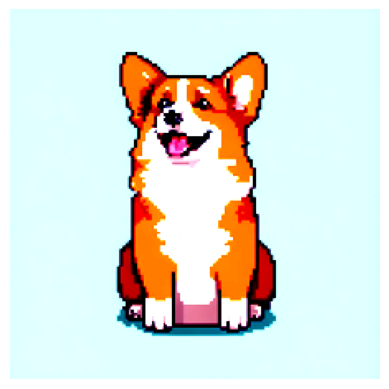

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

img = processed_image.squeeze(0)
img = img.permute(*torch.arange(img.ndim-1, -1, -1))
img = np.einsum('ijk->jik', img)
plt.imshow(img)
plt.axis('off')


In [9]:
image_embedding = model.get_image_features(processed_image)
image_embedding.shape

torch.Size([1, 512])

In [10]:
text_embedding /= text_embedding.norm(dim=-1, keepdim=True)
image_embedding /= image_embedding.norm(dim=-1, keepdim=True)

similarity = (text_embedding @ image_embedding.T).squeeze(0)



print(similarity)

tensor([0.3943], grad_fn=<SqueezeBackward1>)


In [11]:
# 使用sentence-transformers 库简化
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('clip-ViT-B-32')

image_embedding = model.encode(image)
text_embedding = model.encode(caption)

similarity = util.cos_sim(image_embedding, text_embedding)

print(similarity)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


tensor([[0.3943]])


## 使纯文本能力大模型具备多模态能力

BLIP-2：利用查询式 Transformer（Querying Transformer, Q-TFormer）连接预训练视觉编码器和预训练 LLM

包含两个共享注意力层：
  * 图像 Transformer：与冻结的 ViT 交互，提取深层视觉特性
  * 文本 Transformer：对接 LLM，实现语义理解和生成

训练目标：
  * 图像-文本对比学习
  * 图像-文本匹配
  * 基于图像的文本生成

流程：

1. 图像输入预训练的 ViT
2. ViT 输出嵌入输入 Q-Former
3. Q-Former训练，输出学习后的嵌入
4. 嵌入投影到 LLM 的嵌入空间
5. 输入预训练 LLM
6. 生成输出

核心组件：
  * 处理器：将非结构化输入转换为模型所需的规范化表示形式
  * 模型：

In [12]:
import torch
from transformers import AutoProcessor, Blip2ForConditionalGeneration
from util import init_torch_device


device = 'cpu'

blip_processor = AutoProcessor.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    revision="51572668da0eb669e01a189dc22abe6088589a24"  # Choose specific model because of: https://huggingface.co/Salesforce/blip2-opt-2.7b/discussions/39
)
model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    revision="51572668da0eb669e01a189dc22abe6088589a24",
    torch_dtype=torch.float16
)
model.to('cpu')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
  )
  (qf

In [13]:
inputs = blip_processor(image, return_tensors='pt').to(device, torch.float16)

inputs['pixel_values'].shape


torch.Size([1, 3, 224, 224])

In [14]:
blip_processor.tokenizer

GPT2TokenizerFast(name_or_path='Salesforce/blip2-opt-2.7b', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50265: AddedToken("<image>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [15]:
text = 'Her vocalization was remarkably melodic'
token_ids = blip_processor.tokenizer(text, return_tensors='pt').to(device)["input_ids"][0]

tokens = blip_processor.tokenizer.convert_ids_to_tokens(token_ids)
tokens

['</s>', 'Her', 'Ġvocal', 'ization', 'Ġwas', 'Ġremarkably', 'Ġmel', 'odic']

In [16]:
[token.replace('Ġ', '_') for token in tokens]

['</s>', 'Her', '_vocal', 'ization', '_was', '_remarkably', '_mel', 'odic']

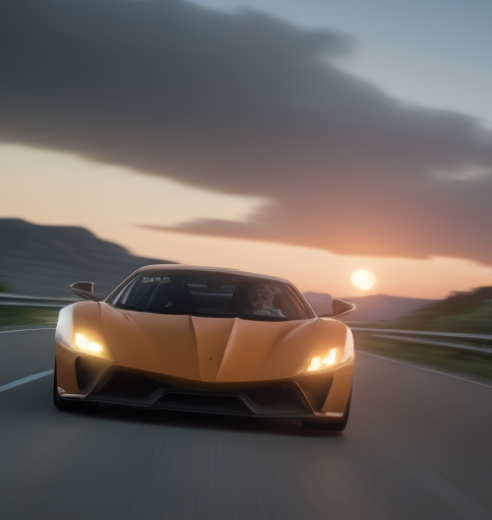

In [17]:
from urllib.request import urlopen

car_path = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/car.png"
image = Image.open(urlopen(car_path)).convert('RGB')
inputs = blip_processor(image, return_tensors='pt').to(device, torch.float16)
image



In [18]:
generated_ids = model.generate(
    **inputs, max_new_tokens=20
)
generated_text = blip_processor.decode(
    generated_ids[0], skip_special_tokens=True
)
generated_text

Expanding inputs for image tokens in BLIP-2 should be done in processing. Please follow instruction here (https://gist.github.com/zucchini-nlp/e9f20b054fa322f84ac9311d9ab67042) to update your BLIP-2 model. Using processors without these attributes in the config is deprecated and will throw an error in v4.50.
Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


'a\n'

In [19]:
url = "https://upload.wikimedia.org/wikipedia/commons/7/70/Rorschach_blot_01.jpg"
image = Image.open(urlopen(url)).convert("RGB")

# Generate caption
inputs = blip_processor(image, return_tensors="pt").to(device, torch.float16)
generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_text = generated_text[0].strip()
generated_text

KeyboardInterrupt: 

In [20]:
image = Image.open('resources/x8_upscaled__00144_.png').convert('RGB')
prompt = 'Question: Write down what you see in the picture. Answer: '

inputs = blip_processor(image, text=prompt, return_tensors='pt').to(device, torch.float16)
generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_text = generated_text[0].strip()

print(generated_text)

Expanding inputs for image tokens in BLIP-2 should be done in processing. Please follow instruction here (https://gist.github.com/zucchini-nlp/e9f20b054fa322f84ac9311d9ab67042) to update your BLIP-2 model. Using processors without these attributes in the config is deprecated and will throw an error in v4.50.
Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Question: Write down what you see in the picture. Answer:


In [23]:
from IPython.display import HTML, display
import ipywidgets as widgets


memory = []
output = widgets.Output()
in_text = widgets.Text()
in_text.continuous_update = False


def text_event_handler(*args):
    question = args[0]['new']
    if question:
        print(args[0])
        args[0]['owner'].value = ''
        if not memory:
            prompt = f"Question: {question}. Answer: "
        else:
            prompt = ' '.join(
                f'Question: {q}. Answer: {a}' for q, a in memory
            ) + f'Question: {question}. Answer: '
        
        inputs = blip_processor(image, text=prompt, return_tensors='pt').to(device, torch.float16)
        
        generated_ids = model.generate(**inputs, max_new_tokens=20)
        generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)
        generated_text = generated_text[0].strip()
        
        memory.append((question, generated_text))

        output.append_display_data(HTML('<b>User: </b>' + question))
        output.append_display_data(HTML('<b>BLIP-2: </b>' + generated_text))
        output.append_display_data(HTML('<br>'))


in_text.observe(text_event_handler, names='value')
display(
    widgets.VBox(
        children=[output, in_text],
        layout=widgets.Layout(width='inline-flex', height='column-reverse')
    )
)  

{'name': 'value', 'old': '', 'new': 'abc', 'owner': Text(value='abc', continuous_update=False), 'type': 'change'}


Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


{'name': 'value', 'old': '', 'new': 'test', 'owner': Text(value='test', continuous_update=False), 'type': 'change'}


Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


{'name': 'value', 'old': '', 'new': 'what is the image about?', 'owner': Text(value='what is the image about?', continuous_update=False), 'type': 'change'}


Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
